In [1]:
# from google.colab import drive
# drive.mount('/content/drive')
# %cd /content/drive/MyDrive/Colab Notebooks

<a id='0'></a>
# Part 1. Problem Definition

This problem is to design an automated trading solution for single stock trading. We model the stock trading process as a Markov Decision Process (MDP). We then formulate our trading goal as a maximization problem.

The algorithm is trained using Deep Reinforcement Learning (DRL) algorithms and the components of the reinforcement learning environment are:


* Action: The action space describes the allowed actions that the agent interacts with the
environment. Normally, a ∈ A includes three actions: a ∈ {−1, 0, 1}, where −1, 0, 1 represent
selling, holding, and buying one stock. Also, an action can be carried upon multiple shares. We use
an action space {−k, ..., −1, 0, 1, ..., k}, where k denotes the number of shares. For example, "Buy
10 shares of AAPL" or "Sell 10 shares of AAPL" are 10 or −10, respectively

* Reward function: r(s, a, s′) is the incentive mechanism for an agent to learn a better action. The change of the portfolio value when action a is taken at state s and arriving at new state s',  i.e., r(s, a, s′) = v′ − v, where v′ and v represent the portfolio
values at state s′ and s, respectively

* State: The state space describes the observations that the agent receives from the environment. Just as a human trader needs to analyze various information before executing a trade, so
our trading agent observes many different features to better learn in an interactive environment.

* Environment: Dow 30 constituents


The data of the single stock that we will be using for this case study is obtained from Yahoo Finance API. The data contains Open-High-Low-Close price and volume.


<a id='1'></a>
# Part 2. Getting Started- Load Python Packages

<a id='1.1'></a>
## 2.1. Install all the packages through FinRL library

In [2]:
# # ## install finrl library
# !pip install wrds
# !pip install swig
# !pip install -q condacolab
# import condacolab
# condacolab.install()
# !apt-get update -y -qq && apt-get install -y -qq cmake libopenmpi-dev python3-dev zlib1g-dev libgl1-mesa-glx swig
# !pip install git+https://github.com/AI4Finance-Foundation/FinRL.git



<a id='1.2'></a>
## 2.2. Check if the additional packages needed are present, if not install them.
* Yahoo Finance API
* pandas
* numpy
* matplotlib
* stockstats
* OpenAI gym
* stable-baselines
* tensorflow
* pyfolio

<a id='1.3'></a>
## 2.3. Import Packages

In [3]:
import warnings
warnings.filterwarnings("ignore")

<a id='1.3.1'></a>
### 2.3.a. Colab

In [4]:
# import pandas as pd
# import numpy as np
# import matplotlib
# import matplotlib.pyplot as plt
# # matplotlib.use('Agg')
# import datetime

# %matplotlib inline
# from finrl.config_tickers import DOW_30_TICKER
# from finrl.meta.preprocessor.yahoodownloader import YahooDownloader
# from finrl.meta.preprocessor.preprocessors import FeatureEngineer, data_split
# from finrl.meta.env_stock_trading.env_stocktrading import StockTradingEnv
# from finrl.agents.stablebaselines3.models import DRLAgent,DRLEnsembleAgent
# from finrl.plot import backtest_stats, backtest_plot, get_daily_return, get_baseline
# from stable_baselines3.common.logger import configure
# from stable_baselines3 import A2C, DDPG, PPO, SAC, TD3

# from pprint import pprint

# # import sys
# # sys.path.append("../FinRL-Library")

# import itertools

<a id='1.3'></a>
### 2.3.b. Local

In [5]:
import sys
import itertools
import pandas as pd
import numpy as np
import matplotlib
import matplotlib.pyplot as plt

import copy
import datetime
from copy import deepcopy
import pyfolio
from pyfolio import timeseries

# matplotlib.use('Agg')
sys.path.append('D:\\Learning\\University\\UIT\\AI\\Projects\\AI4Finance\\FinRL')

%matplotlib inline
from finrl import config
from finrl.config_tickers import DOW_30_TICKER
from finrl.meta.preprocessor.yahoodownloader import YahooDownloader
from finrl.meta.preprocessor.preprocessors import FeatureEngineer, data_split
from finrl.meta.env_stock_trading.env_stocktrading import StockTradingEnv
from finrl.agents.stablebaselines3.models import DRLAgent,DRLEnsembleAgent
from finrl.plot import backtest_stats, backtest_plot, get_daily_return, get_baseline
from stable_baselines3.common.logger import configure
from stable_baselines3 import A2C, DDPG, PPO, SAC, TD3

from pprint import pprint

import itertools

<a id='2'></a>
# Part 3. Download Data
Yahoo Finance is a website that provides stock data, financial news, financial reports, etc. All the data provided by Yahoo Finance is free.
* FinRL uses a class **YahooDownloader** to fetch data from Yahoo Finance API
* Call Limit: Using the Public API (without authentication), you are limited to 2,000 requests per hour per IP (or up to a total of 48,000 requests a day).




-----
class YahooDownloader:
    Provides methods for retrieving daily stock data from
    Yahoo Finance API

    Attributes
    ----------
        start_date : str
            start date of the data (modified from config.py)
        end_date : str
            end date of the data (modified from config.py)
        ticker_list : list
            a list of stock tickers (modified from config.py)

    Methods
    -------
    fetch_data()
        Fetches data from yahoo API


In [6]:
import os
from finrl.main import check_and_make_directories
from finrl.config import (
    DATA_SAVE_DIR,
    TRAINED_MODEL_DIR,
    TENSORBOARD_LOG_DIR,
    RESULTS_DIR,
    INDICATORS,
    TRAIN_START_DATE,
    TRAIN_END_DATE,
    TEST_START_DATE,
    TEST_END_DATE,
    TRADE_START_DATE,
    TRADE_END_DATE,
)

check_and_make_directories([DATA_SAVE_DIR, TRAINED_MODEL_DIR, TENSORBOARD_LOG_DIR, RESULTS_DIR])

In [7]:
print(DOW_30_TICKER)

['AXP', 'AMGN', 'AAPL', 'BA', 'CAT', 'CSCO', 'CVX', 'GS', 'HD', 'HON', 'IBM', 'INTC', 'JNJ', 'KO', 'JPM', 'MCD', 'MMM', 'MRK', 'MSFT', 'NKE', 'PG', 'TRV', 'UNH', 'CRM', 'VZ', 'V', 'WBA', 'WMT', 'DIS', 'DOW']


In [8]:
TRAIN_START_DATE = '2015-01-01'
TRAIN_END_DATE = '2020-10-01'
TEST_START_DATE = '2020-10-01'
TEST_END_DATE = '2024-06-15'

In [9]:
df = YahooDownloader(start_date=TRAIN_START_DATE,
                    end_date= TEST_END_DATE,
                    ticker_list = DOW_30_TICKER ).fetch_data()

[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%*******

Shape of DataFrame:  (70311, 8)


In [10]:
df.head()

date        open        high         low       close     volume  \
0  2015-01-02   27.847500   27.860001   26.837500   24.435268  212818400   
1  2015-01-02  160.160004  162.589996  158.600006  122.031860    2605400   
2  2015-01-02   93.169998   93.940002   92.139999   80.772041    2437500   
3  2015-01-02  131.070007  131.839996  129.089996  113.657219    4294200   
4  2015-01-02   91.769997   92.370003   90.660004   70.907600    3767900   

    tic  day  
0  AAPL    4  
1  AMGN    4  
2   AXP    4  
3    BA    4  
4   CAT    4

In [11]:
df.tail()

date        open        high         low       close    volume  \
70306  2024-06-14  496.829987  497.850006  491.730011  497.119995   3025400   
70307  2024-06-14  270.100006  271.549988  269.269989  270.660004   8501000   
70308  2024-06-14   39.480000   39.840000   39.450001   39.669998  10381800   
70309  2024-06-14   15.370000   15.560000   15.160000   15.550000   9013600   
70310  2024-06-14   66.540001   67.110001   66.300003   67.019997  12587500   

       tic  day  
70306  UNH    4  
70307    V    4  
70308   VZ    4  
70309  WBA    4  
70310  WMT    4

In [12]:
df.shape

(70311, 8)

In [13]:
df.sort_values(['date','tic']).head()

date        open        high         low       close     volume  \
0  2015-01-02   27.847500   27.860001   26.837500   24.435268  212818400   
1  2015-01-02  160.160004  162.589996  158.600006  122.031860    2605400   
2  2015-01-02   93.169998   93.940002   92.139999   80.772041    2437500   
3  2015-01-02  131.070007  131.839996  129.089996  113.657219    4294200   
4  2015-01-02   91.769997   92.370003   90.660004   70.907600    3767900   

    tic  day  
0  AAPL    4  
1  AMGN    4  
2   AXP    4  
3    BA    4  
4   CAT    4

In [14]:
print(f"Unique stock: {len(df['tic'].unique())}")

Unique stock: 30


In [15]:
df['tic'].value_counts()

tic
AAPL    2379
AMGN    2379
WMT     2379
WBA     2379
VZ      2379
V       2379
UNH     2379
TRV     2379
PG      2379
NKE     2379
MSFT    2379
MRK     2379
MMM     2379
MCD     2379
KO      2379
JPM     2379
JNJ     2379
INTC    2379
IBM     2379
HON     2379
HD      2379
GS      2379
DIS     2379
CVX     2379
CSCO    2379
CRM     2379
CAT     2379
BA      2379
AXP     2379
DOW     1320
Name: count, dtype: int64

# Part 4: Preprocess Data
Data preprocessing is a crucial step for training a high quality machine learning model. We need to check for missing data and do feature engineering in order to convert the data into a model-ready state.
* Add technical indicators. In practical trading, various information needs to be taken into account, for example the historical stock prices, current holding shares, technical indicators, etc. In this article, we demonstrate two trend-following technical indicators: MACD and RSI.
* Add turbulence index. Risk-aversion reflects whether an investor will choose to preserve the capital. It also influences one's trading strategy when facing different market volatility level. To control the risk in a worst-case scenario, such as financial crisis of 2007–2008, FinRL employs the financial turbulence index that measures extreme asset price fluctuation.

In [16]:
INDICATORS = ['macd',
            'rsi_30',
            'cci_30',
            'dx_30']

In [17]:
fe = FeatureEngineer(
                    use_technical_indicator=True,
                    tech_indicator_list = INDICATORS,
                    use_vix=True,
                    use_turbulence=True,
                    user_defined_feature = False)

processed = fe.preprocess_data(df)

Successfully added technical indicators


[*********************100%%**********************]  1 of 1 completed


Shape of DataFrame:  (2378, 8)
Successfully added vix
Successfully added turbulence index


In [18]:
list_ticker = processed["tic"].unique().tolist()
list_date = list(pd.date_range(processed['date'].min(),processed['date'].max()).astype(str))
combination = list(itertools.product(list_date,list_ticker))

processed_full = pd.DataFrame(combination,columns=["date","tic"]).merge(processed,on=["date","tic"],how="left")
processed_full = processed_full[processed_full['date'].isin(processed['date'])]
processed_full = processed_full.sort_values(['date','tic'])

processed_full = processed_full.fillna(0)

In [19]:
processed_full.sort_values(['date','tic'],ignore_index=True).head(10)

date   tic        open        high         low       close  \
0  2015-01-02  AAPL   27.847500   27.860001   26.837500   24.435268   
1  2015-01-02  AMGN  160.160004  162.589996  158.600006  122.031860   
2  2015-01-02   AXP   93.169998   93.940002   92.139999   80.772041   
3  2015-01-02    BA  131.070007  131.839996  129.089996  113.657219   
4  2015-01-02   CAT   91.769997   92.370003   90.660004   70.907600   
5  2015-01-02   CRM   59.900002   60.430000   58.509998   59.162720   
6  2015-01-02  CSCO   27.860001   28.120001   27.379999   20.657425   
7  2015-01-02   CVX  111.629997  113.000000  110.849998   75.044235   
8  2015-01-02   DIS   94.910004   95.279999   92.849998   87.092415   
9  2015-01-02    GS  195.300003  195.729996  192.699997  161.304276   

        volume  day  macd  rsi_30     cci_30  dx_30        vix  turbulence  
0  212818400.0  4.0   0.0     0.0 -66.666667  100.0  17.790001         0.0  
1    2605400.0  4.0   0.0     0.0 -66.666667  100.0  17.790001         0.0  
2    2437500.0  4.0   0.0     0.0 -66.666667  100.0  17.790001         0.0  
3    4294200.0  4.0   0.0     0.0 -66.666667  100.0  17.790001         0.0  
4    3767900.0  4.0   0.0     0.0 -66.666667  100.0  17.790001         0.0  
5    2796400.0  4.0   0.0     0.0 -66.666667  100.0  17.790001         0.0  
6   22926500.0  4.0   0.0     0.0 -66.666667  100.0  17.790001         0.0  
7    5898800.0  4.0   0.0     0.0 -66.666667  100.0  17.790001         0.0  
8    5865400.0  4.0   0.0     0.0 -66.666667  100.0  17.790001         0.0  
9    1877700.0  4.0   0.0     0.0 -66.666667  100.0  17.790001         0.0

In [20]:
mvo_df = processed_full.sort_values(['date','tic'],ignore_index=True)[['date','tic','close']]

<a id='4'></a>
# Part 5. Build A Market Environment in OpenAI Gym-style
The training process involves observing stock price change, taking an action and reward's calculation. By interacting with the market environment, the agent will eventually derive a trading strategy that may maximize (expected) rewards.

Our market environment, based on OpenAI Gym, simulates stock markets with historical market data.

## Data Split
We split the data into training set and testing set as follows:

Training data period: 2015-10-19 to 2023-04-10

Testing data period: 2023-04-10 to 2024-05-31


In [21]:
train = data_split(processed_full, TRAIN_START_DATE,TRAIN_END_DATE)
test = data_split(processed_full, TEST_START_DATE,TEST_END_DATE)
print(len(train))
print(len(test))

41963
26999


In [22]:
test.tail()

date  tic        open        high         low       close  \
930  2024-06-13  UNH  490.279999  502.000000  484.380005  497.299988   
930  2024-06-13    V  270.320007  271.859985  269.320007  271.190002   
930  2024-06-13   VZ   39.750000   39.799999   39.299999   39.779999   
930  2024-06-13  WBA   15.500000   15.550000   15.210000   15.450000   
930  2024-06-13  WMT   66.300003   66.760002   65.949997   66.699997   

         volume  day      macd     rsi_30     cci_30      dx_30    vix  \
930   4951700.0  3.0 -1.120635  49.937124 -59.266035  11.461158  11.94   
930   7361200.0  3.0 -0.550888  47.083243 -81.584123   2.434985  11.94   
930  12297400.0  3.0  0.103771  48.827088 -52.638282  13.133763  11.94   
930   7908200.0  3.0 -0.477351  38.683156 -92.164101  27.449984  11.94   
930  11196600.0  3.0  1.398586  65.178852  73.776417  31.828260  11.94   

     turbulence  
930   14.062682  
930   14.062682  
930   14.062682  
930   14.062682  
930   14.062682

In [23]:
test.head()

date   tic        open        high         low       close  \
0  2020-10-01  AAPL  117.639999  117.720001  115.830002  114.419518   
0  2020-10-01  AMGN  255.070007  258.510010  254.050003  227.129425   
0  2020-10-01   AXP  100.330002  101.480003   99.370003   96.422256   
0  2020-10-01    BA  170.149994  172.759995  165.570007  167.860001   
0  2020-10-01   CAT  149.919998  150.309998  145.649994  135.630310   

        volume  day      macd     rsi_30      cci_30      dx_30        vix  \
0  116120400.0  3.0 -0.311373  55.324095  -11.056533   4.545971  26.700001   
0    2428300.0  3.0  1.203310  56.058377  151.021839  12.794623  26.700001   
0    4179300.0  3.0 -0.476114  52.017754  -10.218143   4.201357  26.700001   
0   30677100.0  3.0 -1.865163  50.028520   34.123745  13.735273  26.700001   
0    2157400.0  3.0  0.993800  54.259428   13.900075  18.442236  26.700001   

   turbulence  
0    13.89527  
0    13.89527  
0    13.89527  
0    13.89527  
0    13.89527

In [24]:
stock_dimension = len(train.tic.unique())
state_space = 1 + 2*stock_dimension + len(INDICATORS)*stock_dimension
print(f"Stock Dimension: {stock_dimension}, State Space: {state_space}")

Stock Dimension: 29, State Space: 175


In [26]:
import gym
from gym import spaces
from gym.utils import seeding
from stable_baselines3.common.vec_env import DummyVecEnv

class StockTradingEnv(gym.Env):
    """A stock trading environment for OpenAI gym"""

    metadata = {"render.modes": ["human"]}

    def __init__(
        self,
        df: pd.DataFrame,
        stock_dim: int,
        hmax: int,
        initial_amount: int,
        num_stock_shares: list[int],
        buy_cost_pct: list[float],
        sell_cost_pct: list[float],
        reward_scaling: float,
        state_space: int,
        action_space: int,
        tech_indicator_list: list[str],
        turbulence_threshold=None,
        risk_indicator_col="turbulence",
        make_plots: bool = False,
        print_verbosity=10,
        day=0,
        initial=True,
        previous_state=[],
        model_name="",
        mode="",
        iteration="",
    ):
        self.day = day
        self.df = df
        self.stock_dim = stock_dim
        self.hmax = hmax
        self.num_stock_shares = num_stock_shares
        self.initial_amount = initial_amount  # get the initial cash
        self.buy_cost_pct = buy_cost_pct
        self.sell_cost_pct = sell_cost_pct
        self.reward_scaling = reward_scaling
        self.state_space = state_space
        self.action_space = action_space
        self.tech_indicator_list = tech_indicator_list
        self.action_space = spaces.Box(low=-1, high=1, shape=(self.action_space,))
        self.observation_space = spaces.Box(
            low=-np.inf, high=np.inf, shape=(self.state_space,)
        )
        self.data = self.df.loc[self.day, :]
        self.terminal = False
        self.make_plots = make_plots
        self.print_verbosity = print_verbosity
        self.turbulence_threshold = turbulence_threshold
        self.risk_indicator_col = risk_indicator_col
        self.initial = initial
        self.previous_state = previous_state
        self.model_name = model_name
        self.mode = mode
        self.iteration = iteration
        # initalize state
        self.state = self._initiate_state()

        # initialize reward
        self.reward = 0
        self.turbulence = 0
        self.cost = 0
        self.trades = 0
        self.episode = 0
        # memorize all the total balance change
        self.asset_memory = [
            self.initial_amount
            + np.sum(
                np.array(self.num_stock_shares)
                * np.array(self.state[1 : 1 + self.stock_dim])
            )
        ]  # the initial total asset is calculated by cash + sum (num_share_stock_i * price_stock_i)
        self.rewards_memory = []
        self.actions_memory = []
        self.state_memory = (
            []
        )  # we need sometimes to preserve the state in the middle of trading process
        self.date_memory = [self._get_date()]
        #         self.logger = Logger('results',[CSVOutputFormat])
        # self.reset()
        self._seed()

    def _sell_stock(self, index, action):
        def _do_sell_normal():
            if (
                self.state[index + 2 * self.stock_dim + 1] != True
            ):  # check if the stock is able to sell, for simlicity we just add it in techical index
                # if self.state[index + 1] > 0: # if we use price<0 to denote a stock is unable to trade in that day, the total asset calculation may be wrong for the price is unreasonable
                # Sell only if the price is > 0 (no missing data in this particular date)
                # perform sell action based on the sign of the action
                if self.state[index + self.stock_dim + 1] > 0:
                    # Sell only if current asset is > 0
                    sell_num_shares = min(
                        abs(action), self.state[index + self.stock_dim + 1]
                    )
                    sell_amount = (
                        self.state[index + 1]
                        * sell_num_shares
                        * (1 - self.sell_cost_pct[index])
                    )
                    # update balance
                    self.state[0] += sell_amount

                    self.state[index + self.stock_dim + 1] -= sell_num_shares
                    self.cost += (
                        self.state[index + 1]
                        * sell_num_shares
                        * self.sell_cost_pct[index]
                    )
                    self.trades += 1
                else:
                    sell_num_shares = 0
            else:
                sell_num_shares = 0

            return sell_num_shares

        # perform sell action based on the sign of the action
        if self.turbulence_threshold is not None:
            if self.turbulence >= self.turbulence_threshold:
                print("turbulence goes over threshold!")
                if self.state[index + 1] > 0:
                    # Sell only if the price is > 0 (no missing data in this particular date)
                    # if turbulence goes over threshold, just clear out all positions
                    if self.state[index + self.stock_dim + 1] > 0:
                        # Sell only if current asset is > 0
                        sell_num_shares = self.state[index + self.stock_dim + 1]
                        sell_amount = (
                            self.state[index + 1]
                            * sell_num_shares
                            * (1 - self.sell_cost_pct[index])
                        )
                        # update balance
                        self.state[0] += sell_amount
                        self.state[index + self.stock_dim + 1] = 0
                        self.cost += (
                            self.state[index + 1]
                            * sell_num_shares
                            * self.sell_cost_pct[index]
                        )
                        self.trades += 1
                    else:
                        sell_num_shares = 0
                else:
                    sell_num_shares = 0
            else:
                sell_num_shares = _do_sell_normal()
        else:
            sell_num_shares = _do_sell_normal()

        return sell_num_shares

    def _buy_stock(self, index, action):
        def _do_buy():
            if (
                self.state[index + 2 * self.stock_dim + 1] != True
            ):  # check if the stock is able to buy
                # if self.state[index + 1] >0:
                # Buy only if the price is > 0 (no missing data in this particular date)
                available_amount = self.state[0] // (
                    self.state[index + 1] * (1 + self.buy_cost_pct[index])
                )  # when buying stocks, we should consider the cost of trading when calculating available_amount, or we may be have cash<0
                print('available_amount:{}'.format(available_amount))

                # update balance
                buy_num_shares = min(available_amount, action)
                buy_amount = (
                    self.state[index + 1]
                    * buy_num_shares
                    * (1 + self.buy_cost_pct[index])
                )
                self.state[0] -= buy_amount

                self.state[index + self.stock_dim + 1] += buy_num_shares

                self.cost += (
                    self.state[index + 1] * buy_num_shares * self.buy_cost_pct[index]
                )
                self.trades += 1
            else:
                buy_num_shares = 0

            return buy_num_shares

        # perform buy action based on the sign of the action
        if self.turbulence_threshold is None:
            buy_num_shares = _do_buy()
        else:
            if self.turbulence < self.turbulence_threshold:
                buy_num_shares = _do_buy()
            else:
                buy_num_shares = 0
                pass

        return buy_num_shares

    def _make_plot(self):
        plt.plot(self.asset_memory, "r")
        plt.savefig(f"results/account_value_trade_{self.episode}.png")
        plt.close()

    def step(self, actions):
        self.terminal = self.day >= len(self.df.index.unique()) - 1
        if self.terminal:
            print(f"Episode: {self.episode}")
            if self.make_plots:
                self._make_plot()
            end_total_asset = self.state[0] + sum(
                np.array(self.state[1 : (self.stock_dim + 1)])
                * np.array(self.state[(self.stock_dim + 1) : (self.stock_dim * 2 + 1)])
            )
            df_total_value = pd.DataFrame(self.asset_memory)
            tot_reward = (
                self.state[0]
                + sum(
                    np.array(self.state[1 : (self.stock_dim + 1)])
                    * np.array(
                        self.state[(self.stock_dim + 1) : (self.stock_dim * 2 + 1)]
                    )
                )
                - self.asset_memory[0]
            )  # initial_amount is only cash part of our initial asset
            df_total_value.columns = ["account_value"]
            df_total_value["date"] = self.date_memory
            df_total_value["daily_return"] = df_total_value["account_value"].pct_change(
                1
            )
            if df_total_value["daily_return"].std() != 0:
                sharpe = (
                    (252**0.5)
                    * df_total_value["daily_return"].mean()
                    / df_total_value["daily_return"].std()
                )
            df_rewards = pd.DataFrame(self.rewards_memory)
            df_rewards.columns = ["account_rewards"]
            df_rewards["date"] = self.date_memory[:-1]
            if self.episode % self.print_verbosity == 0:
                print(f"day: {self.day}, episode: {self.episode}")
                print(f"begin_total_asset: {self.asset_memory[0]:0.2f}")
                print(f"end_total_asset: {end_total_asset:0.2f}")
                print(f"total_reward: {tot_reward:0.2f}")
                print(f"total_cost: {self.cost:0.2f}")
                print(f"total_trades: {self.trades}")
                if df_total_value["daily_return"].std() != 0:
                    print(f"Sharpe: {sharpe:0.3f}")
                print("=================================")

            if (self.model_name != "") and (self.mode != ""):
                df_actions = self.save_action_memory()
                df_actions.to_csv(
                    "results/actions_{}_{}_{}.csv".format(
                        self.mode, self.model_name, self.iteration
                    )
                )
                df_total_value.to_csv(
                    "results/account_value_{}_{}_{}.csv".format(
                        self.mode, self.model_name, self.iteration
                    ),
                    index=False,
                )
                df_rewards.to_csv(
                    "results/account_rewards_{}_{}_{}.csv".format(
                        self.mode, self.model_name, self.iteration
                    ),
                    index=False,
                )
                plt.plot(self.asset_memory, "r")
                plt.savefig(
                    "results/account_value_{}_{}_{}.png".format(
                        self.mode, self.model_name, self.iteration
                    )
                )
                plt.close()

            # Add outputs to logger interface
            # logger.record("environment/portfolio_value", end_total_asset)
            # logger.record("environment/total_reward", tot_reward)
            # logger.record("environment/total_reward_pct", (tot_reward / (end_total_asset - tot_reward)) * 100)
            # logger.record("environment/total_cost", self.cost)
            # logger.record("environment/total_trades", self.trades)

            return self.state, self.reward, self.terminal, False, {}

        else:
            actions = actions * self.hmax  # actions initially is scaled between 0 to 1
            actions = actions.astype(
                int
            )  # convert into integer because we can't by fraction of shares
            if self.turbulence_threshold is not None:
                if self.turbulence >= self.turbulence_threshold:
                    actions = np.array([-self.hmax] * self.stock_dim)
            begin_total_asset = self.state[0] + sum(
                np.array(self.state[1 : (self.stock_dim + 1)])
                * np.array(self.state[(self.stock_dim + 1) : (self.stock_dim * 2 + 1)])
            )
            print("begin_total_asset:{}".format(begin_total_asset))

            argsort_actions = np.argsort(actions)
            sell_index = argsort_actions[: np.where(actions < 0)[0].shape[0]]
            buy_index = argsort_actions[::-1][: np.where(actions > 0)[0].shape[0]]

            for index in sell_index:
                print(f"Num shares before: {self.state[index+self.stock_dim+1]}")
                print(f'take sell action before : {actions[index]}')
                actions[index] = self._sell_stock(index, actions[index]) * (-1)
                print(f'take sell action after : {actions[index]}')
                print(f"Num shares after: {self.state[index+self.stock_dim+1]}")

            for index in buy_index:
                print('take buy action: {}'.format(actions[index]))
                actions[index] = self._buy_stock(index, actions[index])

            self.actions_memory.append(actions)

            # state: s -> s+1
            self.day += 1
            self.data = self.df.loc[self.day, :]
            if self.turbulence_threshold is not None:
                if len(self.df.tic.unique()) == 1:
                    self.turbulence = self.data[self.risk_indicator_col]
                elif len(self.df.tic.unique()) > 1:
                    self.turbulence = self.data[self.risk_indicator_col].values[0]
            self.state = self._update_state()

            end_total_asset = self.state[0] + sum(
                np.array(self.state[1 : (self.stock_dim + 1)])
                * np.array(self.state[(self.stock_dim + 1) : (self.stock_dim * 2 + 1)])
            )
            self.asset_memory.append(end_total_asset)
            self.date_memory.append(self._get_date())
            self.reward = end_total_asset - begin_total_asset
            self.rewards_memory.append(self.reward)
            self.reward = self.reward * self.reward_scaling
            self.state_memory.append(
                self.state
            )  # add current state in state_recorder for each step

        return self.state, self.reward, self.terminal, False, {}

    def reset(
        self,
        *,
        seed=None,
        options=None,
    ):
        # initiate state
        self.day = 0
        self.data = self.df.loc[self.day, :]
        self.state = self._initiate_state()

        if self.initial:
            self.asset_memory = [
                self.initial_amount
                + np.sum(
                    np.array(self.num_stock_shares)
                    * np.array(self.state[1 : 1 + self.stock_dim])
                )
            ]
        else:
            previous_total_asset = self.previous_state[0] + sum(
                np.array(self.state[1 : (self.stock_dim + 1)])
                * np.array(
                    self.previous_state[(self.stock_dim + 1) : (self.stock_dim * 2 + 1)]
                )
            )
            self.asset_memory = [previous_total_asset]

        self.turbulence = 0
        self.cost = 0
        self.trades = 0
        self.terminal = False
        # self.iteration=self.iteration
        self.rewards_memory = []
        self.actions_memory = []
        self.date_memory = [self._get_date()]

        self.episode += 1

        return self.state, {}

    def render(self, mode="human", close=False):
        return self.state

    def _initiate_state(self):
        if self.initial:
            # For Initial State
            if len(self.df.tic.unique()) > 1:
                # for multiple stock
                state = (
                    [self.initial_amount]
                    + self.data.close.values.tolist()
                    + self.num_stock_shares
                    + sum(
                        (
                            self.data[tech].values.tolist()
                            for tech in self.tech_indicator_list
                        ),
                        [],
                    )
                )  # append initial stocks_share to initial state, instead of all zero
            else:
                # for single stock
                state = (
                    [self.initial_amount]
                    + [self.data.close]
                    + [0] * self.stock_dim
                    + sum(([self.data[tech]] for tech in self.tech_indicator_list), [])
                )
        else:
            # Using Previous State
            if len(self.df.tic.unique()) > 1:
                # for multiple stock
                state = (
                    [self.previous_state[0]]
                    + self.data.close.values.tolist()
                    + self.previous_state[
                        (self.stock_dim + 1) : (self.stock_dim * 2 + 1)
                    ]
                    + sum(
                        (
                            self.data[tech].values.tolist()
                            for tech in self.tech_indicator_list
                        ),
                        [],
                    )
                )
            else:
                # for single stock
                state = (
                    [self.previous_state[0]]
                    + [self.data.close]
                    + self.previous_state[
                        (self.stock_dim + 1) : (self.stock_dim * 2 + 1)
                    ]
                    + sum(([self.data[tech]] for tech in self.tech_indicator_list), [])
                )
        return state

    def _update_state(self):
        if len(self.df.tic.unique()) > 1:
            # for multiple stock
            state = (
                [self.state[0]]
                + self.data.close.values.tolist()
                + list(self.state[(self.stock_dim + 1) : (self.stock_dim * 2 + 1)])
                + sum(
                    (
                        self.data[tech].values.tolist()
                        for tech in self.tech_indicator_list
                    ),
                    [],
                )
            )

        else:
            # for single stock
            state = (
                [self.state[0]]
                + [self.data.close]
                + list(self.state[(self.stock_dim + 1) : (self.stock_dim * 2 + 1)])
                + sum(([self.data[tech]] for tech in self.tech_indicator_list), [])
            )

        return state

    def _get_date(self):
        if len(self.df.tic.unique()) > 1:
            date = self.data.date.unique()[0]
        else:
            date = self.data.date
        return date

    # add save_state_memory to preserve state in the trading process
    def save_state_memory(self):
        if len(self.df.tic.unique()) > 1:
            # date and close price length must match actions length
            date_list = self.date_memory[:-1]
            df_date = pd.DataFrame(date_list)
            df_date.columns = ["date"]

            state_list = self.state_memory
            df_states = pd.DataFrame(
                state_list,
                columns=[
                    "cash",
                    "Bitcoin_price",
                    "Gold_price",
                    "Bitcoin_num",
                    "Gold_num",
                    "Bitcoin_Disable",
                    "Gold_Disable",
                ],
            )
            df_states.index = df_date.date
            # df_actions = pd.DataFrame({'date':date_list,'actions':action_list})
        else:
            date_list = self.date_memory[:-1]
            state_list = self.state_memory
            df_states = pd.DataFrame({"date": date_list, "states": state_list})
        # print(df_states)
        return df_states

    def save_asset_memory(self):
        date_list = self.date_memory
        asset_list = self.asset_memory
        # print(len(date_list))
        # print(len(asset_list))
        df_account_value = pd.DataFrame(
            {"date": date_list, "account_value": asset_list}
        )
        return df_account_value

    def save_action_memory(self):
        if len(self.df.tic.unique()) > 1:
            # date and close price length must match actions length
            date_list = self.date_memory[:-1]
            df_date = pd.DataFrame(date_list)
            df_date.columns = ["date"]

            action_list = self.actions_memory
            df_actions = pd.DataFrame(action_list)
            df_actions.columns = self.data.tic.values
            df_actions.index = df_date.date
            # df_actions = pd.DataFrame({'date':date_list,'actions':action_list})
        else:
            date_list = self.date_memory[:-1]
            action_list = self.actions_memory
            df_actions = pd.DataFrame({"date": date_list, "actions": action_list})
        return df_actions

    def _seed(self, seed=None):
        self.np_random, seed = seeding.np_random(seed)
        return [seed]

    def get_sb_env(self):
        e = DummyVecEnv([lambda: self])
        obs = e.reset()
        return e, obs


In [27]:
buy_cost_list = sell_cost_list = [0.001] * stock_dimension
num_stock_shares = [0] * stock_dimension

env_kwargs = {
    "hmax": 100,
    "initial_amount": 1000000,
    "num_stock_shares": num_stock_shares,
    "buy_cost_pct": buy_cost_list,
    "sell_cost_pct": sell_cost_list,
    "state_space": state_space,
    "stock_dim": stock_dimension,
    "tech_indicator_list": INDICATORS,
    "action_space": stock_dimension,
    "reward_scaling": 1e-4
}

e_train_gym = StockTradingEnv(df = train, **env_kwargs)

## In-sample Performance

Assume that the initial capital is $1,000,000.

In [28]:
if_using_a2c = True
if_using_ddpg = True
if_using_ppo = True
if_using_td3 = False
if_using_sac = False

### Set turbulence threshold
Set the turbulence threshold to be greater than the maximum of insample turbulence data. If current turbulence index is greater than the threshold, then we assume that the current market is volatile

In [29]:
data_risk_indicator = processed_full[(processed_full.date<TRAIN_END_DATE) & (processed_full.date>=TRAIN_START_DATE)]
insample_risk_indicator = data_risk_indicator.drop_duplicates(subset=['date'])

In [30]:
insample_risk_indicator.vix.describe()

count    1447.000000
mean       17.131113
std         8.204512
min         9.140000
25%        12.500000
50%        14.650000
75%        19.000000
max        82.690002
Name: vix, dtype: float64

In [31]:
insample_risk_indicator.vix.quantile(0.996)

65.64800091552729

In [32]:
insample_risk_indicator.turbulence.describe()

count    1447.000000
mean       35.106378
std        54.663242
min         0.000000
25%        11.221368
50%        22.331543
75%        38.805744
max       652.615835
Name: turbulence, dtype: float64

In [33]:
insample_risk_indicator.turbulence.quantile(0.996)

447.8814918753646

In [34]:
buy_cost_list = sell_cost_list = [0.001] * stock_dimension
num_stock_shares = [0] * stock_dimension

env_kwargs = {
    "hmax": 100,
    "initial_amount": 1000000,
    "num_stock_shares": num_stock_shares,
    "buy_cost_pct": buy_cost_list,
    "sell_cost_pct": sell_cost_list,
    "state_space": state_space,
    "stock_dim": stock_dimension,
    "tech_indicator_list": INDICATORS,
    "action_space": stock_dimension,
    "reward_scaling": 1e-4
}

e_train_gym = StockTradingEnv(df = train, **env_kwargs)

In [35]:
env_train, _ = e_train_gym.get_sb_env()
print(type(env_train))

<class 'stable_baselines3.common.vec_env.dummy_vec_env.DummyVecEnv'>


### Trading (Out-of-sample Performance)

We update periodically in order to take full advantage of the data, e.g., retrain quarterly, monthly or weekly. We also tune the parameters along the way, in this notebook we use the in-sample data from 2009-01 to 2020-07 to tune the parameters once, so there is some alpha decay here as the length of trade date extends.

Numerous hyperparameters – e.g. the learning rate, the total number of samples to train on – influence the learning process and are usually determined by testing some variations.

In [37]:
e_test_gym = StockTradingEnv(df = test, turbulence_threshold = 70,risk_indicator_col='vix', **env_kwargs)
# env_trade, obs_trade = e_trade_gym.get_sb_env()

In [38]:
test.head()

date   tic        open        high         low       close  \
0  2020-10-01  AAPL  117.639999  117.720001  115.830002  114.419518   
0  2020-10-01  AMGN  255.070007  258.510010  254.050003  227.129425   
0  2020-10-01   AXP  100.330002  101.480003   99.370003   96.422256   
0  2020-10-01    BA  170.149994  172.759995  165.570007  167.860001   
0  2020-10-01   CAT  149.919998  150.309998  145.649994  135.630310   

        volume  day      macd     rsi_30      cci_30      dx_30        vix  \
0  116120400.0  3.0 -0.311373  55.324095  -11.056533   4.545971  26.700001   
0    2428300.0  3.0  1.203310  56.058377  151.021839  12.794623  26.700001   
0    4179300.0  3.0 -0.476114  52.017754  -10.218143   4.201357  26.700001   
0   30677100.0  3.0 -1.865163  50.028520   34.123745  13.735273  26.700001   
0    2157400.0  3.0  0.993800  54.259428   13.900075  18.442236  26.700001   

   turbulence  
0    13.89527  
0    13.89527  
0    13.89527  
0    13.89527  
0    13.89527

In [39]:
trained_a2c = A2C.load(TRAINED_MODEL_DIR + "/agent_a2c") if if_using_a2c else None
trained_ddpg = DDPG.load(TRAINED_MODEL_DIR + "/agent_ddpg") if if_using_ddpg else None
trained_ppo = PPO.load(TRAINED_MODEL_DIR + "/agent_ppo") if if_using_ppo else None
trained_td3 = TD3.load(TRAINED_MODEL_DIR + "/agent_td3") if if_using_td3 else None
trained_sac = SAC.load(TRAINED_MODEL_DIR + "/agent_sac") if if_using_sac else None

In [40]:
train_model = trained_a2c
df_account_value_a2c, df_actions_a2c = DRLAgent.DRL_prediction(
    model=train_model,
    environment = e_test_gym) if if_using_a2c else None

begin_total_asset:1000000.0
Num shares before: 0
take sell action before : -100
take sell action after : 0
Num shares after: 0
Num shares before: 0
take sell action before : -81
take sell action after : 0
Num shares after: 0
Num shares before: 0
take sell action before : -57
take sell action after : 0
Num shares after: 0
Num shares before: 0
take sell action before : -56
take sell action after : 0
Num shares after: 0
Num shares before: 0
take sell action before : -51
take sell action after : 0
Num shares after: 0
Num shares before: 0
take sell action before : -51
take sell action after : 0
Num shares after: 0
Num shares before: 0
take sell action before : -20
take sell action after : 0
Num shares after: 0
Num shares before: 0
take sell action before : -17
take sell action after : 0
Num shares after: 0
Num shares before: 0
take sell action before : -16
take sell action after : 0
Num shares after: 0
Num shares before: 0
take sell action before : -16
take sell action after : 0
Num shares 

In [41]:
train_model = trained_ddpg
df_account_value_ddpg, df_actions_ddpg = DRLAgent.DRL_prediction(
    model=train_model,
    environment = e_test_gym) if if_using_ddpg else None

begin_total_asset:1000000.0
Num shares before: 0
take sell action before : -100
take sell action after : 0
Num shares after: 0
Num shares before: 0
take sell action before : -100
take sell action after : 0
Num shares after: 0
Num shares before: 0
take sell action before : -100
take sell action after : 0
Num shares after: 0
Num shares before: 0
take sell action before : -100
take sell action after : 0
Num shares after: 0
Num shares before: 0
take sell action before : -100
take sell action after : 0
Num shares after: 0
Num shares before: 0
take sell action before : -100
take sell action after : 0
Num shares after: 0
Num shares before: 0
take sell action before : -100
take sell action after : 0
Num shares after: 0
Num shares before: 0
take sell action before : -100
take sell action after : 0
Num shares after: 0
Num shares before: 0
take sell action before : -100
take sell action after : 0
Num shares after: 0
Num shares before: 0
take sell action before : -100
take sell action after : 0
Nu

In [42]:
train_model = trained_ppo
df_account_value_ppo, df_actions_ppo = DRLAgent.DRL_prediction(
    model=train_model,
    environment = e_test_gym) if if_using_ppo else None

begin_total_asset:1000000.0
Num shares before: 0
take sell action before : -20
take sell action after : 0
Num shares after: 0
Num shares before: 0
take sell action before : -20
take sell action after : 0
Num shares after: 0
Num shares before: 0
take sell action before : -17
take sell action after : 0
Num shares after: 0
Num shares before: 0
take sell action before : -15
take sell action after : 0
Num shares after: 0
Num shares before: 0
take sell action before : -12
take sell action after : 0
Num shares after: 0
Num shares before: 0
take sell action before : -11
take sell action after : 0
Num shares after: 0
Num shares before: 0
take sell action before : -9
take sell action after : 0
Num shares after: 0
Num shares before: 0
take sell action before : -7
take sell action after : 0
Num shares after: 0
Num shares before: 0
take sell action before : -5
take sell action after : 0
Num shares after: 0
Num shares before: 0
take sell action before : -4
take sell action after : 0
Num shares after

begin_total_asset:1000564.7360009272
Num shares before: 0
take sell action before : -20
take sell action after : 0
Num shares after: 0
Num shares before: 0
take sell action before : -20
take sell action after : 0
Num shares after: 0
Num shares before: 0
take sell action before : -17
take sell action after : 0
Num shares after: 0
Num shares before: 0
take sell action before : -15
take sell action after : 0
Num shares after: 0
Num shares before: 0
take sell action before : -12
take sell action after : 0
Num shares after: 0
Num shares before: 0
take sell action before : -11
take sell action after : 0
Num shares after: 0
Num shares before: 0
take sell action before : -9
take sell action after : 0
Num shares after: 0
Num shares before: 0
take sell action before : -7
take sell action after : 0
Num shares after: 0
Num shares before: 0
take sell action before : -5
take sell action after : 0
Num shares after: 0
Num shares before: 0
take sell action before : -4
take sell action after : 0
Num sha

In [43]:

print("==============Compare to DJIA===========")

# S&P 500: ^GSPC
# Dow Jones Index: ^DJI
# NASDAQ 100: ^NDX

if if_using_ppo:
    backtest_plot(df_account_value_ppo,
                    baseline_ticker='^DJI',
                    baseline_start=TEST_START_DATE,
                    baseline_end=TEST_END_DATE)
    plt.show()

if if_using_a2c:
    backtest_plot(df_account_value_a2c,
                    baseline_ticker='^DJI',
                    baseline_start=TEST_START_DATE,
                    baseline_end=TEST_END_DATE)
    plt.show()
    
if if_using_ddpg:
    backtest_plot(df_account_value_ddpg,
                    baseline_ticker='^DJI',
                    baseline_start=TEST_START_DATE,
                    baseline_end=TEST_END_DATE)
    plt.show()


==============Compare to DJIA===========


[*********************100%%**********************]  1 of 1 completed

Shape of DataFrame:  (932, 8)


[*********************100%%**********************]  1 of 1 completed

Shape of DataFrame:  (932, 8)


[*********************100%%**********************]  1 of 1 completed

Shape of DataFrame:  (932, 8)


<a id='7'></a>
# Part 6.5: Mean Variance Optimization

Mean Variance optimization is a very classic strategy in portfolio management. Here, we go through the whole process to do the mean variance optimization and add it as a baseline to compare.

First, process dataframe to the form for MVO weight calculation.

In [44]:
def process_df_for_mvo(df):
  df = df.sort_values(['date','tic'],ignore_index=True)[['date','tic','close']]
  fst = df
  fst = fst.iloc[0:stock_dimension, :]
  tic = fst['tic'].tolist()

  mvo = pd.DataFrame()

  for k in range(len(tic)):
    mvo[tic[k]] = 0

  for i in range(df.shape[0]//stock_dimension):
    n = df
    n = n.iloc[i * stock_dimension:(i+1) * stock_dimension, :]
    date = n['date'][i*stock_dimension]
    mvo.loc[date] = n['close'].tolist()

  return mvo

### Helper functions for mean returns and variance-covariance matrix

In [45]:
# Codes in this section partially refer to Dr G A Vijayalakshmi Pai

# https://www.kaggle.com/code/vijipai/lesson-5-mean-variance-optimization-of-portfolios/notebook

def StockReturnsComputing(StockPrice, Rows, Columns):
  StockReturn = np.zeros([Rows-1, Columns])
  for j in range(Columns):        # j: Assets
    for i in range(Rows-1):     # i: Daily Prices
      StockReturn[i,j]=((StockPrice[i+1, j]-StockPrice[i,j])/StockPrice[i,j])* 100

  return StockReturn

### Calculate the weights for mean-variance

In [46]:
train_mvo = data_split(processed_full, TRAIN_START_DATE,TRAIN_END_DATE).reset_index()
trade_mvo = data_split(processed_full, TEST_START_DATE,TEST_END_DATE).reset_index()

In [47]:
StockData = process_df_for_mvo(train_mvo)
TradeData = process_df_for_mvo(trade_mvo)

TradeData.to_numpy()

array([[114.41951752, 227.12942505,  96.42225647, ...,  48.0989418 ,
         29.68935585,  45.05010986],
       [110.72603607, 218.25376892,  96.68869019, ...,  47.929039  ,
         29.60658646,  44.23777008],
       [114.13539886, 227.68078613,  98.85826111, ...,  48.26884079,
         30.31012154,  44.64709091],
       ...,
       [207.1499939 , 300.70001221, 224.52999878, ...,  40.41999817,
         15.93000031,  66.73000336],
       [213.07000732, 301.07998657, 224.03999329, ...,  39.77000046,
         15.53999996,  66.30999756],
       [214.24000549, 298.5       , 222.19000244, ...,  39.77999878,
         15.44999981,  66.69999695]])

In [48]:
#compute asset returns
arStockPrices = np.asarray(StockData)
[Rows, Cols]=arStockPrices.shape
arReturns = StockReturnsComputing(arStockPrices, Rows, Cols)

#compute mean returns and variance covariance matrix of returns
meanReturns = np.mean(arReturns, axis = 0)
covReturns = np.cov(arReturns, rowvar=False)

#set precision for printing results
np.set_printoptions(precision=3, suppress = True)

#display mean returns and variance-covariance matrix of returns
print('Mean returns of assets in k-portfolio 1\n', meanReturns)
print('Variance-Covariance matrix of returns\n', covReturns)

Mean returns of assets in k-portfolio 1
 [ 0.123  0.056  0.031  0.061  0.064  0.123  0.051  0.006  0.038  0.027
  0.09   0.058  0.009  0.055  0.043  0.057  0.031  0.08   0.023  0.048
  0.127  0.087  0.05   0.024  0.1    0.092  0.041 -0.025  0.053]
Variance-Covariance matrix of returns
 [[3.433 1.452 1.701 2.154 1.722 2.124 1.838 1.597 1.441 1.94  1.587 1.523
  1.467 2.11  0.978 1.707 0.892 1.144 1.366 1.026 2.23  1.484 0.983 1.188
  1.599 1.858 0.674 1.281 0.899]
 [1.452 2.758 1.313 1.235 1.377 1.503 1.412 1.229 1.09  1.497 1.288 1.193
  1.229 1.589 1.158 1.459 0.803 0.887 1.153 1.398 1.559 1.081 0.967 1.086
  1.522 1.375 0.735 1.335 0.889]
 [1.701 1.313 3.841 3.226 2.127 1.729 1.72  2.419 1.916 2.745 1.835 2.136
  1.785 1.893 1.051 2.725 1.22  1.582 1.649 1.144 1.808 1.788 1.014 1.871
  1.915 2.144 0.802 1.501 0.703]
 [2.154 1.235 3.226 7.006 2.618 2.092 1.939 2.957 2.273 2.933 2.226 2.591
  2.154 2.293 1.193 2.938 1.544 1.814 1.846 1.205 2.047 2.166 1.095 2.209
  2.084 2.316 0.913 1.

### Use PyPortfolioOpt

In [49]:
from pypfopt.efficient_frontier import EfficientFrontier

ef_mean = EfficientFrontier(meanReturns, covReturns, weight_bounds=(0, 0.5))
raw_weights_mean = ef_mean.max_sharpe()
cleaned_weights_mean = ef_mean.clean_weights()
mvo_weights = np.array([1000000 * cleaned_weights_mean[i] for i in range(29)])
mvo_weights

array([246650.,      0.,      0.,      0.,      0.,  93760.,      0.,
            0.,      0.,      0.,      0.,      0.,      0.,      0.,
            0.,      0.,      0., 131800.,      0.,      0., 388570.,
            0.,      0.,      0., 139230.,      0.,      0.,      0.,
            0.])

In [50]:
LastPrice = np.array([1/p for p in StockData.tail(1).to_numpy()[0]])
Initial_Portfolio = np.multiply(mvo_weights, LastPrice)
Initial_Portfolio

array([2173.905,    0.   ,    0.   ,    0.   ,    0.   ,  373.558,
          0.   ,    0.   ,    0.   ,    0.   ,    0.   ,    0.   ,
          0.   ,    0.   ,    0.   ,    0.   ,    0.   ,  653.916,
          0.   ,    0.   , 1908.966,    0.   ,    0.   ,    0.   ,
        469.08 ,    0.   ,    0.   ,    0.   ,    0.   ])

In [51]:
Portfolio_Assets = TradeData @ Initial_Portfolio
MVO_result = pd.DataFrame(Portfolio_Assets, columns=["Mean Var"])
MVO_result

Mean Var
2020-10-01  1.007467e+06
2020-10-02  9.871284e+05
2020-10-05  1.008451e+06
2020-10-06  9.897194e+05
2020-10-07  1.010051e+06
...                  ...
2024-06-07  1.725193e+06
2024-06-10  1.725120e+06
2024-06-11  1.765364e+06
2024-06-12  1.790945e+06
2024-06-13  1.793427e+06

[931 rows x 1 columns]

<a id='6'></a>
# Part 7: Backtesting Results
Backtesting plays a key role in evaluating the performance of a trading strategy. Automated backtesting tool is preferred because it reduces the human error. We usually use the Quantopian pyfolio package to backtest our trading strategies. It is easy to use and consists of various individual plots that provide a comprehensive image of the performance of a trading strategy.

In [52]:
unique_trade_date = processed[(processed.date > TEST_START_DATE) & (processed.date <= TEST_END_DATE)].date.unique()

In [53]:
rebalance_window = 63
validation_window = 63

df_trade_date = pd.DataFrame({'datadate':unique_trade_date})

df_account_value=pd.DataFrame()
for i in range(rebalance_window+validation_window, len(unique_trade_date)+1,rebalance_window):
    temp = pd.read_csv('results/account_value_trade_{}_{}.csv'.format('ensemble',i))
    df_account_value = pd.concat([df_account_value, temp], ignore_index=True)
sharpe=(252**0.5)*df_account_value.account_value.pct_change(1).mean()/df_account_value.account_value.pct_change(1).std()
print('Sharpe Ratio: ',sharpe)
df_account_value=df_account_value.join(df_trade_date[validation_window:].reset_index(drop=True))
df_account_value.to_csv('df_account_value.csv')

Sharpe Ratio:  0.8676573588885474


In [54]:
df_result_a2c = df_account_value_a2c.set_index(df_account_value_a2c.columns[0])
df_result_a2c.rename(columns = {'account_value':'a2c'}, inplace = True)
df_result_ddpg = df_account_value_ddpg.set_index(df_account_value_ddpg.columns[0])
df_result_ddpg.rename(columns = {'account_value':'ddpg'}, inplace = True)
df_result_ppo = df_account_value_ppo.set_index(df_account_value_ppo.columns[0])
df_result_ppo.rename(columns = {'account_value':'ppo'}, inplace = True)
df_result_ensemble = pd.DataFrame({'date': df_account_value['datadate'], 'ensemble': df_account_value['account_value']})
df_result_ensemble = df_result_ensemble.set_index('date')

# print("df_result_ensemble.columns: ", df_result_ensemble.columns)
# df_result_ensemble.drop(df_result_ensemble.columns[0], axis = 1)
# print("df_trade_date: ", df_trade_date)
# df_result_ensemble['date'] = df_trade_date['datadate']
# df_result_ensemble['account_value'] = df_account_value['account_value']
# print("df_result_ensemble: ", df_result_ensemble)

df_account_value_a2c.to_csv("df_account_value_a2c.csv")
df_account_value_ddpg.to_csv("df_account_value_ddpg.csv")
df_account_value_ppo.to_csv("df_account_value_ppo.csv")
df_result_ensemble.to_csv("df_result_ensemble.csv")

#baseline stats
print("\n==============Get Baseline Stats===========")
df_dji_ = get_baseline(
        ticker="^DJI",
        start = TRADE_START_DATE,
        end = TRADE_END_DATE)

stats = backtest_stats(df_dji_, value_col_name = 'close')

df_dji = pd.DataFrame()
df_dji['date'] = df_account_value['datadate']
df_dji['dji'] = df_dji_['close'] / df_dji_['close'][0] * env_kwargs["initial_amount"]
df_dji.to_csv("df_dji.csv")
df_dji = df_dji.set_index(df_dji.columns[0])
df_dji.to_csv("df_dji+.csv")

result = pd.DataFrame()
result = pd.merge(result, df_result_a2c, how='outer', left_index=True, right_index=True)
result = pd.merge(result, df_result_ddpg, how='outer', left_index=True, right_index=True)
result = pd.merge(result, df_result_ppo, how='outer', left_index=True, right_index=True)
result = pd.merge(result, MVO_result, how='outer', left_index=True, right_index=True)
result = pd.merge(result, df_dji, how='outer', left_index=True, right_index=True)
result = pd.merge(result, df_result_ensemble, left_index=True, right_index=True)

result.columns = ['a2c', 'ddpg', 'ppo', 'mean var', 'dji', 'ensemble']
print(result.head())

# print("result: ", result)
result.to_csv("result.csv")


==============Get Baseline Stats===========


[*********************100%%**********************]  1 of 1 completed


Shape of DataFrame:  (21, 8)
Annual return         -0.385917
Cumulative returns    -0.039821
Annual volatility      0.128088
Sharpe ratio          -3.931765
Calmar ratio          -7.215712
Stability              0.642177
Max drawdown          -0.053483
Omega ratio            0.463384
Sortino ratio         -4.183273
Skew                        NaN
Kurtosis                    NaN
Tail ratio             0.301420
Daily value at risk   -0.018136
dtype: float64
                     a2c          ddpg           ppo      mean var  \
date                                                                 
2021-01-04  1.113195e+06  1.099020e+06  1.004212e+06  1.045127e+06   
2021-01-05  1.124305e+06  1.107584e+06  1.008534e+06  1.048035e+06   
2021-01-06  1.133184e+06  1.125534e+06  1.022733e+06  1.032353e+06   
2021-01-07  1.136892e+06  1.134921e+06  1.024400e+06  1.056613e+06   
2021-01-08  1.135025e+06  1.139758e+06  1.029992e+06  1.064617e+06   

                     dji      ensemble  
date    

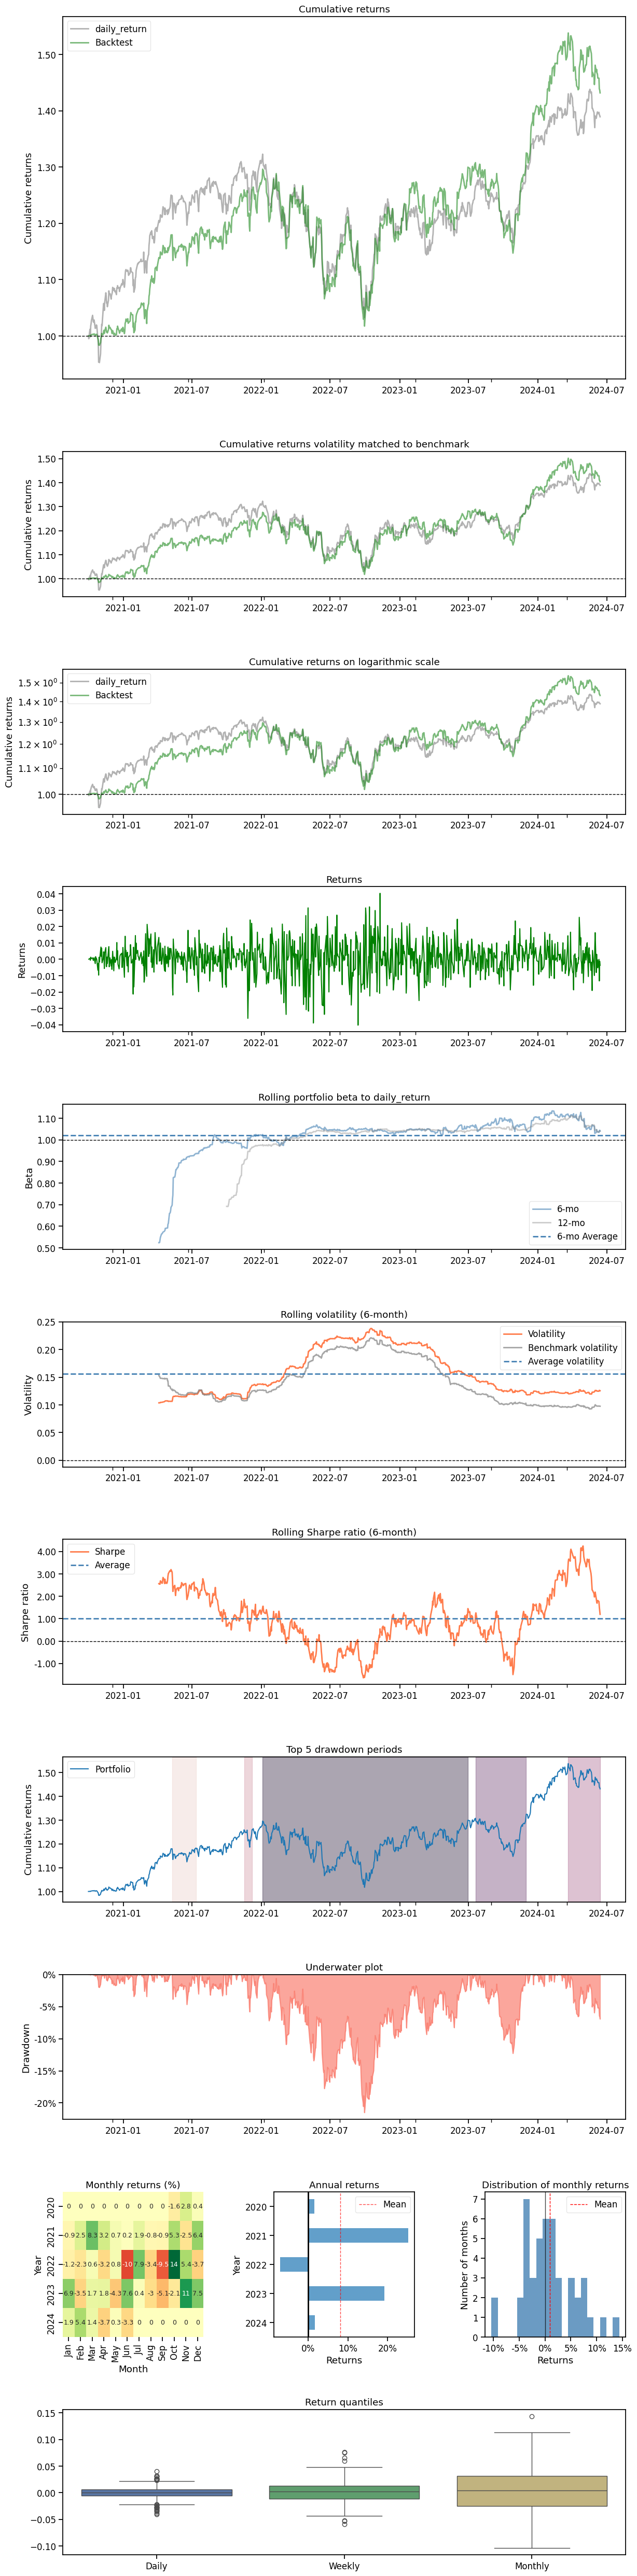

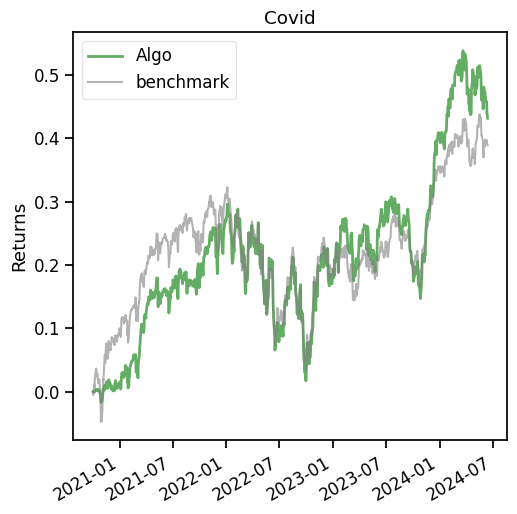

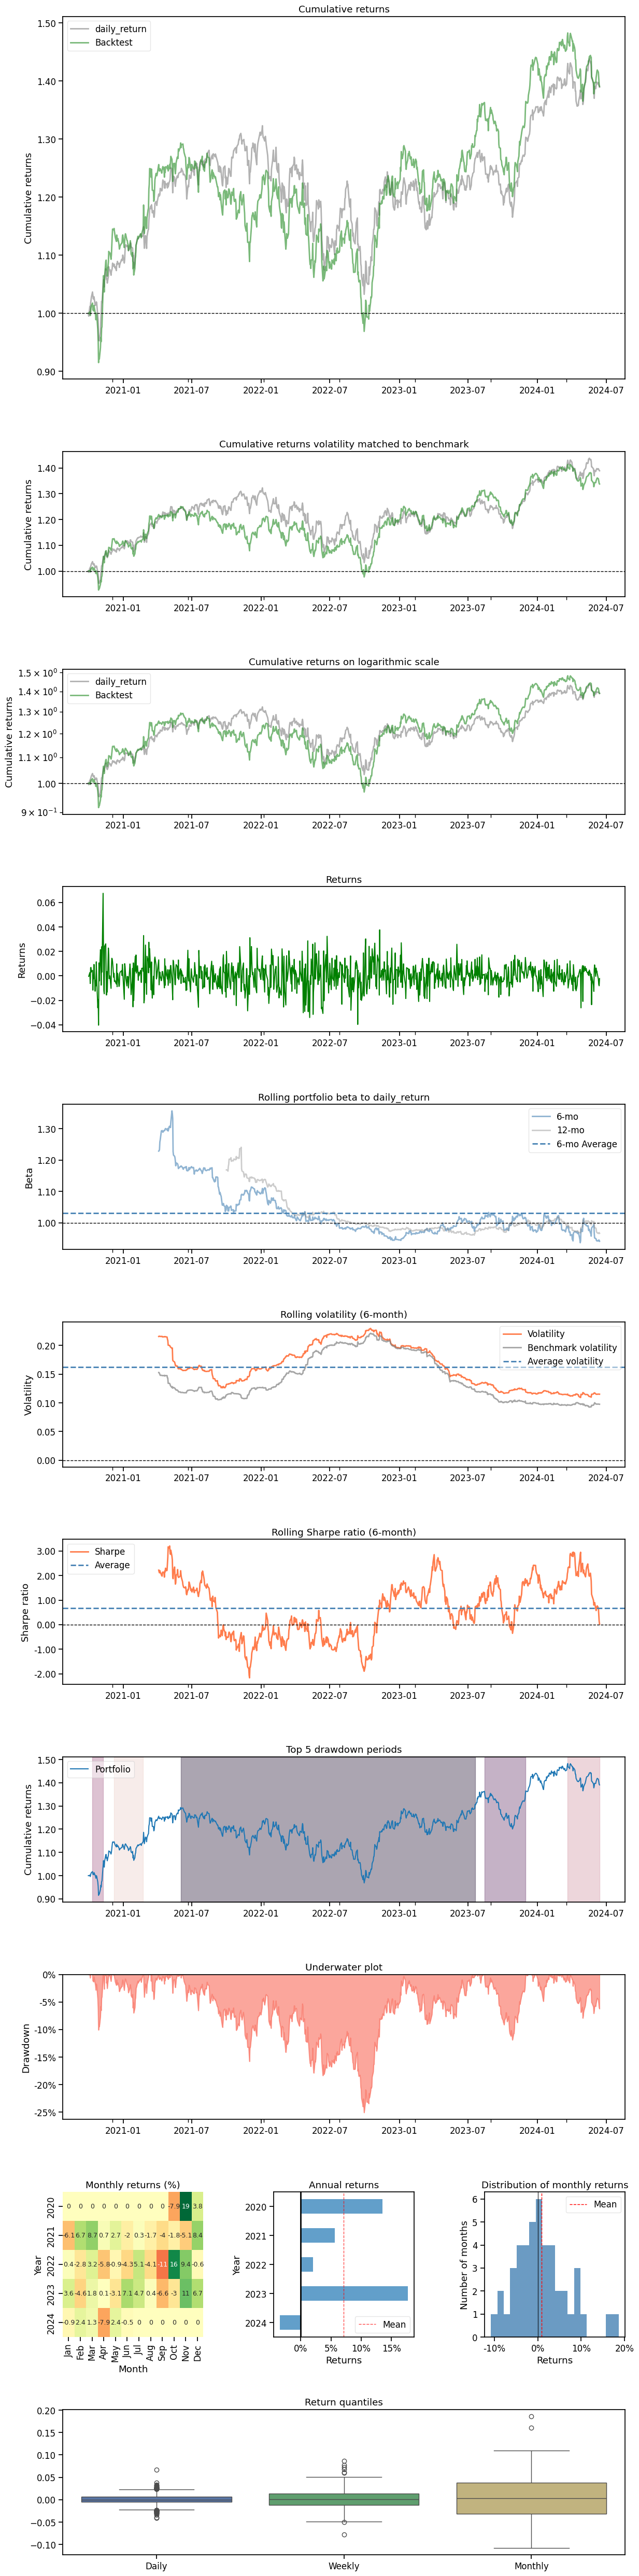

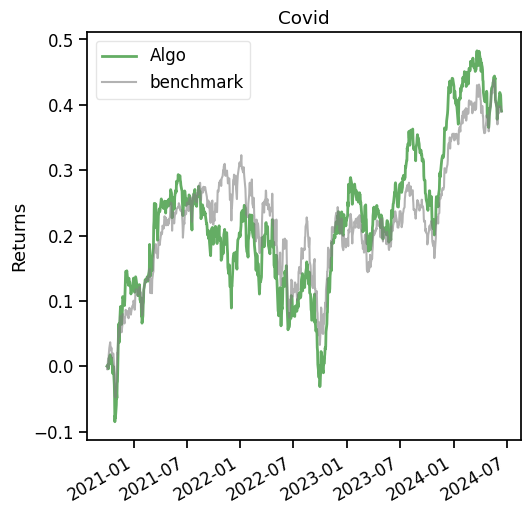

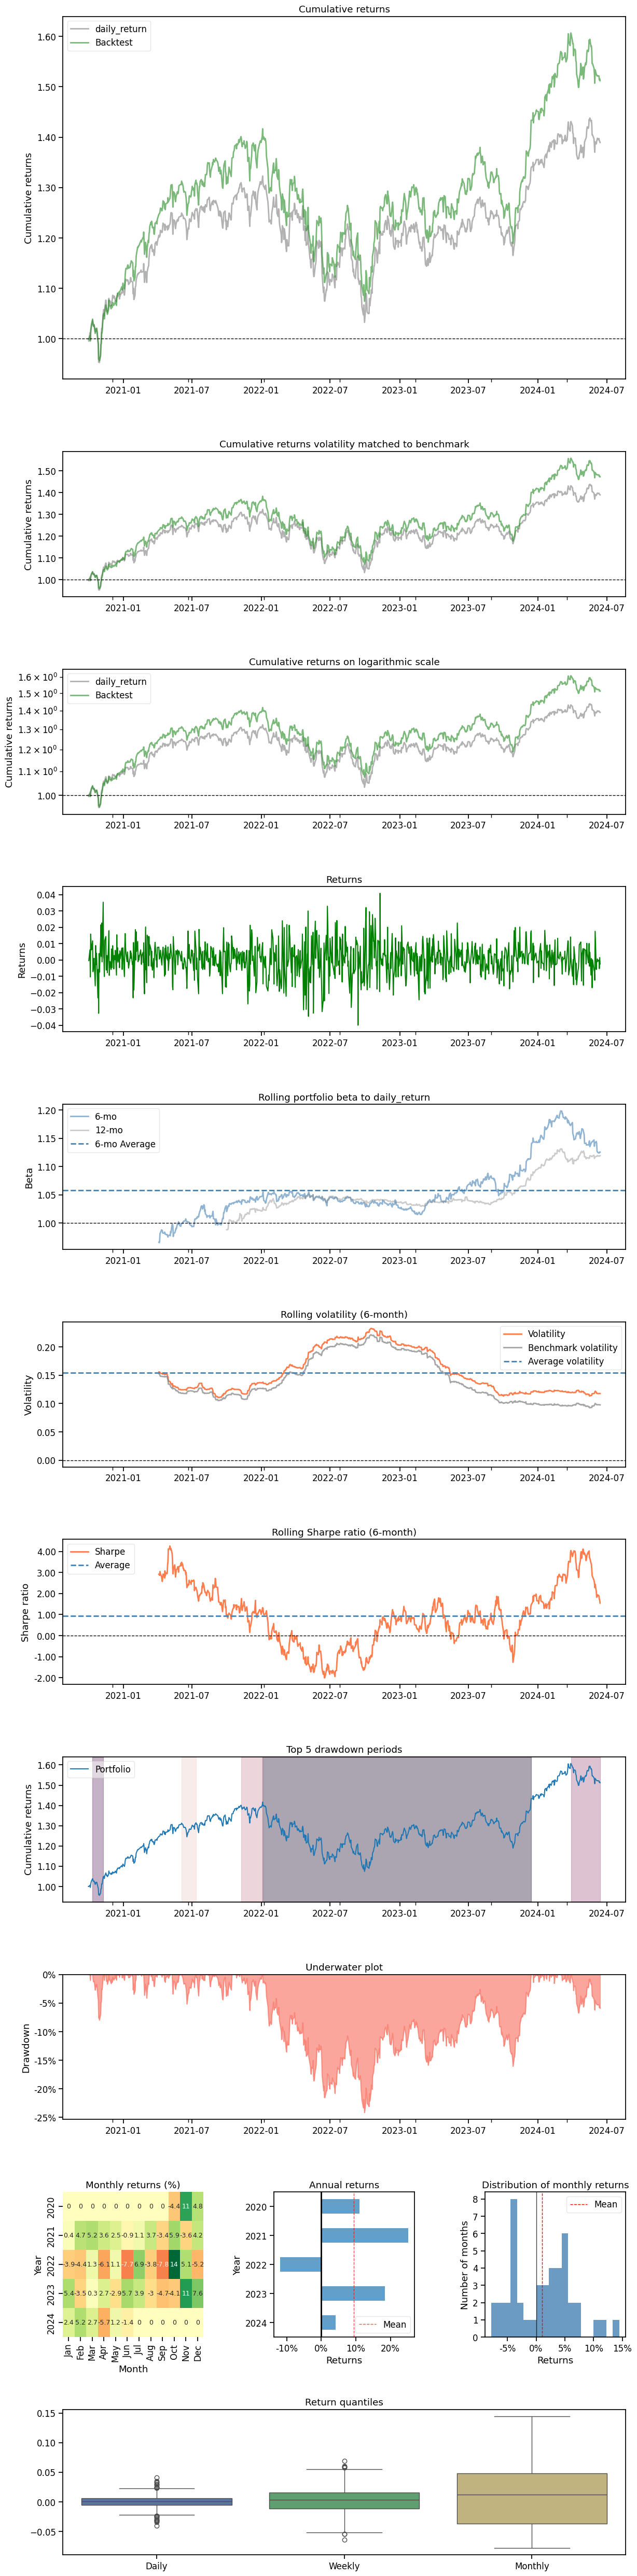

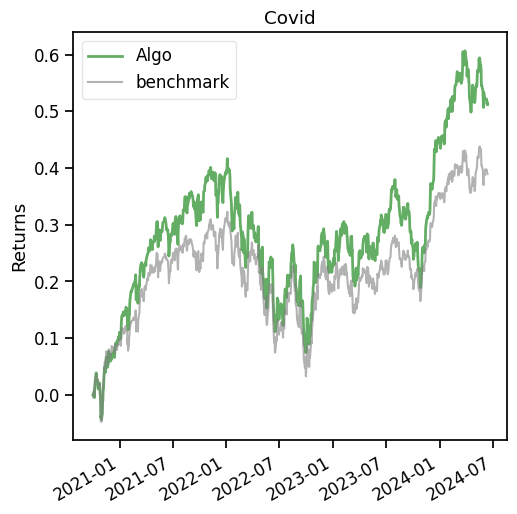

<Figure size 1500x500 with 0 Axes>

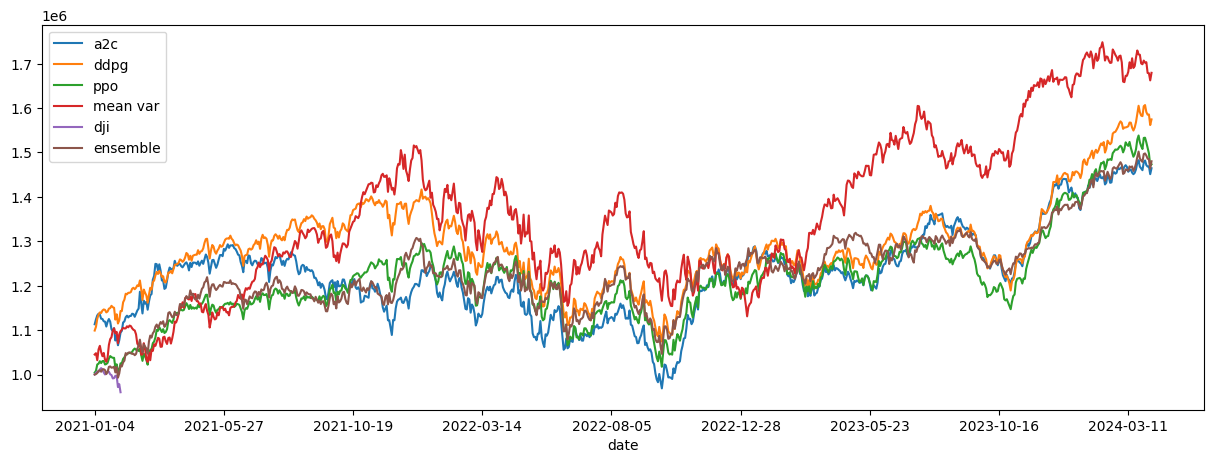

In [55]:
%matplotlib inline
plt.rcParams["figure.figsize"] = (15,5)
plt.figure();
result.plot();